# PRCP-1014

#### Vaccinatino Prediction Description- Project

Team Members: Vivek Viswanathan, Sushree Sarangi, Vartika Vishnoi, and Prabhati Acharya

In [59]:
!pip install pandas_profiling

In [60]:
# Import the necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier
import itertools
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.feature_selection import RFECV
from vecstack import stacking
from mlxtend.classifier import StackingCVClassifier
from mlxtend.plotting import plot_learning_curves, plot_decision_regions
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from sklearn.calibration import CalibratedClassifierCV
from pandas_profiling import ProfileReport
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn import tree
from sklearn.externals.six import StringIO
import graphviz

import warnings
warnings.simplefilter('ignore')

In [61]:
rand_state = 10
n_iterations = 5

In [62]:
# Load the data
feature_data = pd.read_csv('features.csv')

In [63]:
feature_data.head(5)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [64]:
feature_data.shape

(26707, 36)

In [65]:
label_data= pd.read_csv('labels.csv')

In [66]:
label_data.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [67]:
label_data.shape

(26707, 3)

In [68]:
vaccine_data=pd.concat([feature_data, label_data],sort=False,axis=1)

In [69]:
vaccine_data.head(5)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,1,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,2,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,3,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,4,0,0


In [70]:
status = pd.Series([]) 

In [71]:
for i in range(len(vaccine_data)): 
 #for i in range(26707):
    if (vaccine_data["h1n1_vaccine"][i]==1)&(vaccine_data["seasonal_vaccine"][i]==1): 
        status[i]="Low Risk"
  
    #elif [(vaccine_data['h1n1_vaccine'] ==1)|(vaccine_data['seasonal_vaccine']==1)]: 
        #status[i]="Medium Risk"
  
    elif  (vaccine_data["h1n1_vaccine"][i] ==0)&(vaccine_data["seasonal_vaccine"][i]==0): 
        status[i]="High Risk"
  
    else: 
        status[i]= "Medium Risk" 
  
          
# inserting new column with values of list made above         
vaccine_data.insert(39, "status", status) 
  
# list output 
vaccine_data.head(20) 

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,respondent_id,h1n1_vaccine,seasonal_vaccine,status
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0,0,High Risk
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,1,0,1,Medium Risk
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,2,0,0,High Risk
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,3,0,1,Medium Risk
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,4,0,0,High Risk
5,5,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,atmpeygn,"MSA, Principle City",2.0,3.0,saaquncn,vlluhbov,5,0,0,High Risk
6,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,qufhixun,"MSA, Not Principle City",0.0,0.0,xicduogh,xtkaffoo,6,0,0,High Risk
7,7,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,bhuqouqj,Non-MSA,2.0,0.0,pxcmvdjn,xqwwgdyp,7,1,1,Low Risk
8,8,0.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,bhuqouqj,"MSA, Not Principle City",1.0,0.0,xicduogh,ccgxvspp,8,0,0,High Risk
9,9,2.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,qufhixun,"MSA, Not Principle City",0.0,0.0,NaN,NaN,9,0,0,High Risk


In [72]:
print("Shape :",vaccine_data.shape)
print("Rows : ",vaccine_data.shape[0])
print("Columns : ",vaccine_data.shape[1])
print("\nFeatures : \n" ,vaccine_data.columns.tolist())
print("\n Missing Values : ",vaccine_data.isnull().sum().values.sum())
print("\nUnique Values : \n" ,vaccine_data.nunique(dropna=False))

Shape : (26707, 40)
Rows :  26707
Columns :  40

Features : 
 ['respondent_id', 'h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'household_adults', 'household_children', 'employment_industry', 'employment_occupation', 'respondent_id', 'h1n1_vaccine', 'seasonal_vaccine', 'status']

 Missing Values :  60762

Unique Values : 
 respondent_id                  26707
h1n1_concern             

In [73]:
vaccine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [74]:
vaccine_data.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,respondent_id,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,...,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000,26707.000000,26707.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,...,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583,13353.000000,0.212454,0.465608
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,...,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173,7709.791156,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,...,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,6676.500000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,...,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,13353.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,...,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000,20029.500000,0.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,26706.000000,1.000000,1.000000


In [75]:
print('\nUnique values of vaccine_data.h1n1_concern:: \n',vaccine_data.h1n1_concern.value_counts(dropna = False))
print('\nUnique values of vaccine_data.h1n1_knowledge:: \n',vaccine_data.h1n1_knowledge.value_counts(dropna = False))
print('\nUnique values of behavioral_antiviral_meds:: \n',vaccine_data.behavioral_antiviral_meds.value_counts(dropna = False))
print('\nUnique values of vaccine_data.behavioral_avoidance:: \n',vaccine_data.behavioral_avoidance.value_counts(dropna = False))
print('\nUnique values of vaccine_data.behavioral_face_mask:: \n',vaccine_data.behavioral_face_mask.value_counts(dropna = False))
print('\nUnique values of vaccine_data.behavioral_wash_hands:: \n',vaccine_data.behavioral_wash_hands.value_counts(dropna = False))
print('\nUnique values of vaccine_data.behavioral_large_gatherings:: \n',vaccine_data.behavioral_large_gatherings.value_counts(dropna = False))
print('\nUnique values of vaccine_data.behavioral_outside_home:: \n',vaccine_data.behavioral_outside_home.value_counts(dropna = False))
print('\nUnique values of vaccine_data.behavioral_touch_face:: \n',vaccine_data.behavioral_touch_face.value_counts(dropna = False))
print('\nUnique values of vaccine_data.doctor_recc_h1n1 :: \n',vaccine_data.doctor_recc_h1n1 .value_counts(dropna = False))
print('\nUnique values of vaccine_data.doctor_recc_seasonal :: \n',vaccine_data.doctor_recc_seasonal .value_counts(dropna = False))
print('\nUnique values of vaccine_data.chronic_med_condition :: \n',vaccine_data.chronic_med_condition .value_counts(dropna = False))
print('\nUnique values of vaccine_data.child_under_6_months:: \n',vaccine_data.child_under_6_months.value_counts(dropna = False))
print('\nUnique values of vaccine_data.health_worker:: \n',vaccine_data.health_worker.value_counts(dropna = False))
print('\nUnique values of vaccine_data.health_insurance :: \n',vaccine_data.health_insurance .value_counts(dropna = False))
print('\nUnique values of vaccine_data.opinion_h1n1_vacc_effective:: \n',vaccine_data.opinion_h1n1_vacc_effective.value_counts(dropna = False))
print('\nUnique values of vaccine_data.opinion_h1n1_risk:: \n',vaccine_data.opinion_h1n1_risk.value_counts(dropna = False))
print('\nUnique values of vaccine_data.opinion_h1n1_sick_from_vacc:: \n',vaccine_data.opinion_h1n1_sick_from_vacc.value_counts(dropna = False))
print('\nUnique values of vaccine_data.opinion_seas_vacc_effective:: \n',vaccine_data.opinion_seas_vacc_effective.value_counts(dropna = False))
print('\nUnique values of vaccine_data.opinion_seas_risk:: \n',vaccine_data.opinion_seas_risk.value_counts(dropna = False))
print('\nUnique values of vaccine_data.opinion_seas_sick_from_vacc:: \n',vaccine_data.opinion_seas_sick_from_vacc.value_counts(dropna = False))
print('\nUnique values of vaccine_data.age_group:: \n',vaccine_data.age_group.value_counts(dropna = False))
print('\nUnique values of vaccine_data.education :: \n',vaccine_data.education .value_counts(dropna = False))
print('\nUnique values of vaccine_data.race :: \n',vaccine_data.race .value_counts(dropna = False))
print('\nUnique values of vaccine_data.sex  :: \n',vaccine_data.sex  .value_counts(dropna = False))
print('\nUnique values of vaccine_data.income_poverty  :: \n',vaccine_data.income_poverty .value_counts(dropna = False))
print('\nUnique values of vaccine_data.marital_status  :: \n',vaccine_data.marital_status  .value_counts(dropna = False))
print('\nUnique values of vaccine_data.rent_or_own  :: \n',vaccine_data.rent_or_own  .value_counts(dropna = False))
print('\nUnique values of vaccine_data.employment_status  :: \n',vaccine_data.employment_status .value_counts(dropna = False))
print('\nUnique values of vaccine_data.hhs_geo_region   :: \n',vaccine_data.hhs_geo_region .value_counts(dropna = False))
print('\nUnique values of vaccine_data.census_msa   :: \n',vaccine_data.census_msa  .value_counts(dropna = False))
print('\nUnique values of vaccine_data.household_adults:: \n',vaccine_data.household_adults.value_counts(dropna = False))
print('\nUnique values of vaccine_data.household_children:: \n',vaccine_data.household_children.value_counts(dropna = False))
print('\nUnique values of vaccine_data.employment_industry:: \n',vaccine_data.employment_industry.value_counts(dropna = False))
print('\nUnique values of vaccine_data.employment_occupation :: \n',vaccine_data.employment_occupation .value_counts(dropna = False))
print('\nUnique values of vaccine_data.h1n1_vaccine  :: \n',vaccine_data.h1n1_vaccine  .value_counts(dropna = False))
print('\nUnique values of vaccine_data.seasonal_vaccine  :: \n',vaccine_data.seasonal_vaccine .value_counts(dropna = False))



Unique values of vaccine_data.h1n1_concern:: 
 2.0    10575
1.0     8153
3.0     4591
0.0     3296
NaN       92
Name: h1n1_concern, dtype: int64

Unique values of vaccine_data.h1n1_knowledge:: 
 1.0    14598
2.0     9487
0.0     2506
NaN      116
Name: h1n1_knowledge, dtype: int64

Unique values of behavioral_antiviral_meds:: 
 0.0    25335
1.0     1301
NaN       71
Name: behavioral_antiviral_meds, dtype: int64

Unique values of vaccine_data.behavioral_avoidance:: 
 1.0    19228
0.0     7271
NaN      208
Name: behavioral_avoidance, dtype: int64

Unique values of vaccine_data.behavioral_face_mask:: 
 0.0    24847
1.0     1841
NaN       19
Name: behavioral_face_mask, dtype: int64

Unique values of vaccine_data.behavioral_wash_hands:: 
 1.0    22015
0.0     4650
NaN       42
Name: behavioral_wash_hands, dtype: int64

Unique values of vaccine_data.behavioral_large_gatherings:: 
 0.0    17073
1.0     9547
NaN       87
Name: behavioral_large_gatherings, dtype: int64

Unique values of vaccin

In [76]:
vaccine_data.dtypes

respondent_id                    int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                      

###### Grouping columns into Categorical and Continuous column list

In [77]:
# Grouping columns into Categorical and Continuous column list
Catvar_list=['income_poverty','marital_status','rent_or_own','employment_status','hhs_geo_region','census_msa','employment_industry','employment_occupation']
Convar_list=['h1n1_concern','h1n1_knowledge','behavioral_antiviral_meds','behavioral_avoidance','behavioral_face_mask','behavioral_wash_hands','behavioral_large_gatherings','behavioral_outside_home','behavioral_touch_face','household_adults','household_children']


###### Checking the distribution of data for continuous variables

In [78]:
#for i in Convar_list:
    #df[i]=total_data[i].astype('float').astype(int)
    #df[i]=total_data[i]
    #df.dtypes

array([[<AxesSubplot:title={'center':'h1n1_concern'}>,
        <AxesSubplot:title={'center':'h1n1_knowledge'}>,
        <AxesSubplot:title={'center':'behavioral_antiviral_meds'}>],
       [<AxesSubplot:title={'center':'behavioral_avoidance'}>,
        <AxesSubplot:title={'center':'behavioral_face_mask'}>,
        <AxesSubplot:title={'center':'behavioral_wash_hands'}>],
       [<AxesSubplot:title={'center':'behavioral_large_gatherings'}>,
        <AxesSubplot:title={'center':'behavioral_outside_home'}>,
        <AxesSubplot:title={'center':'behavioral_touch_face'}>],
       [<AxesSubplot:title={'center':'household_adults'}>,
        <AxesSubplot:title={'center':'household_children'}>,
        <AxesSubplot:>]], dtype=object)

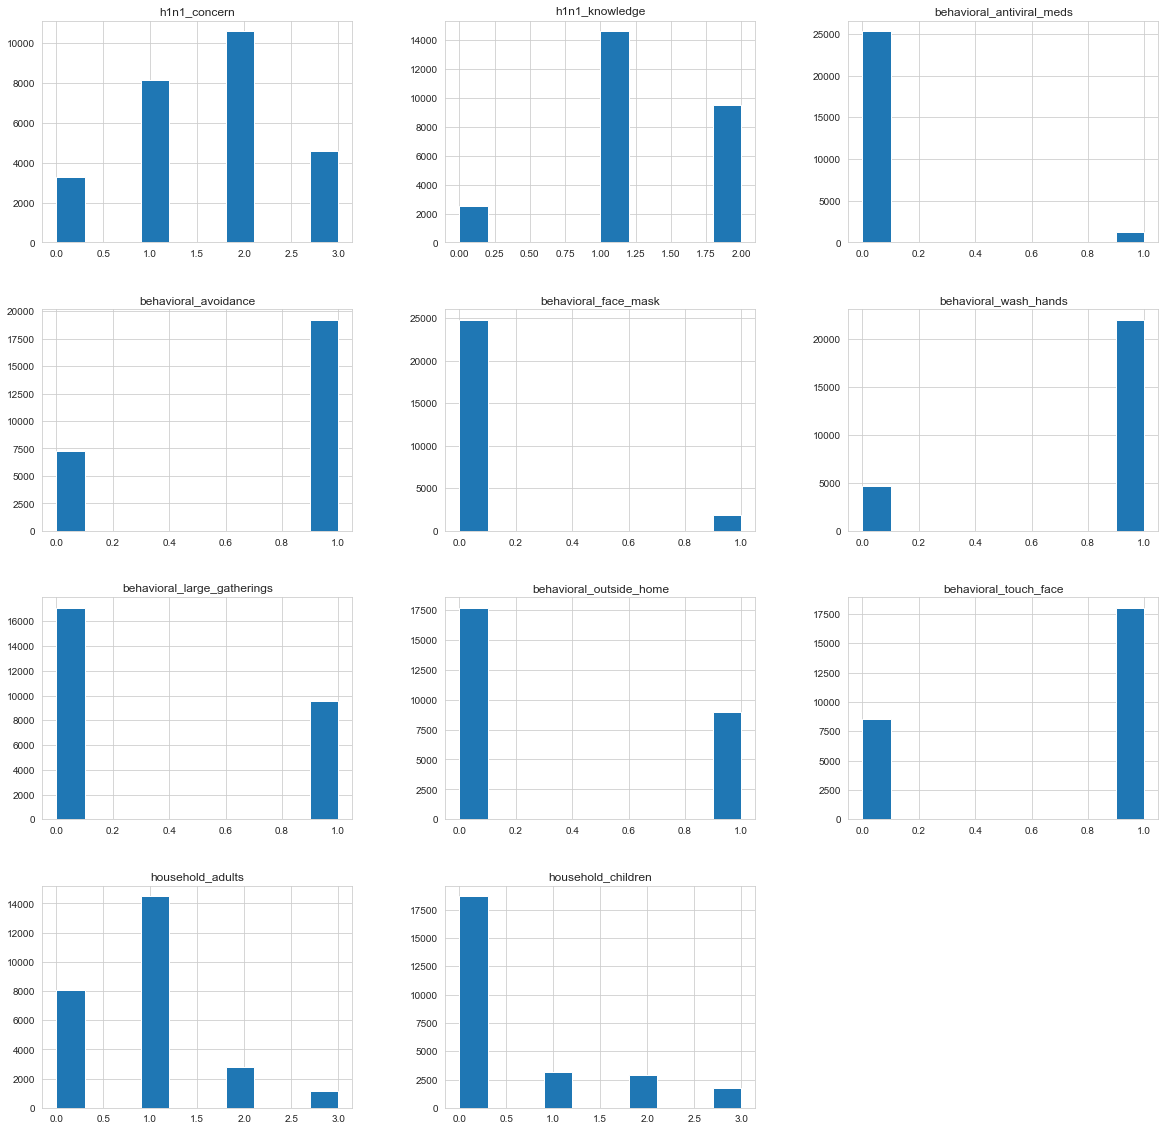

In [79]:
vaccine_data[Convar_list].hist(figsize=(20,20))

###### Checking the Data distribution for the Categorical features

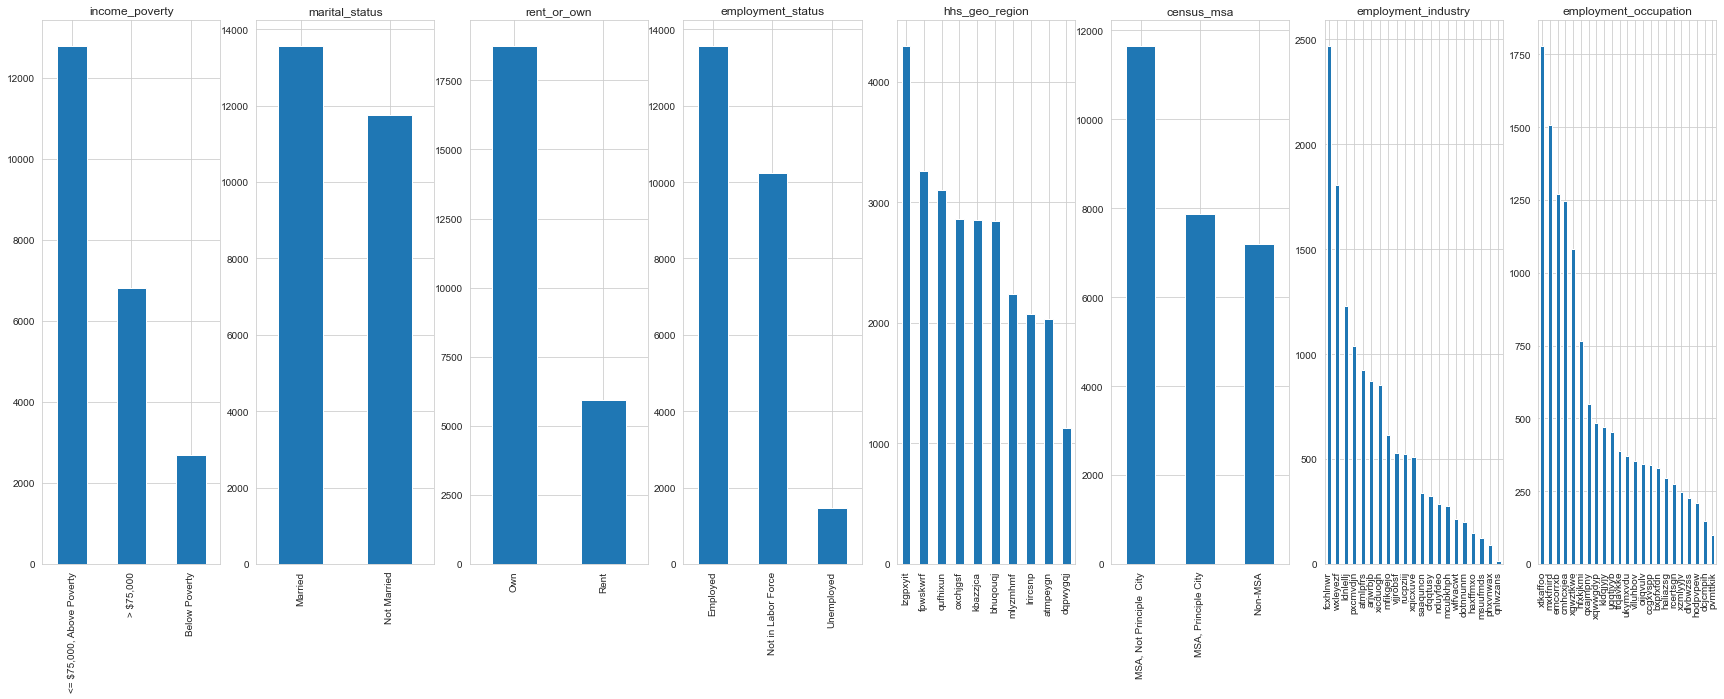

In [80]:
#Plot categorical data using Seaborn's facegrid and Panda's melt function
fig, ax=plt.subplots(1, len(Catvar_list) , figsize=(30,10))
for i, j in enumerate(vaccine_data[Catvar_list]):
    vaccine_data[j].value_counts().plot(kind="bar", ax=ax[i]).set_title(j)
    
fig.show()

###### Correlation Matrix

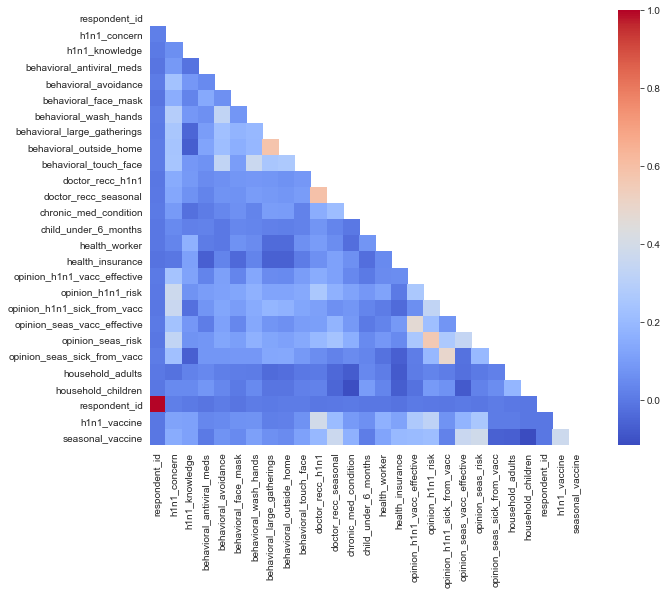

In [81]:
corr=vaccine_data.corr()
mask=np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True

with sns.axes_style("white"):
    f, ax=plt.subplots(figsize=(12,8))
    ax=sns.heatmap(corr,mask=mask,vmax=1,square=True,cmap='coolwarm')

<AxesSubplot:>

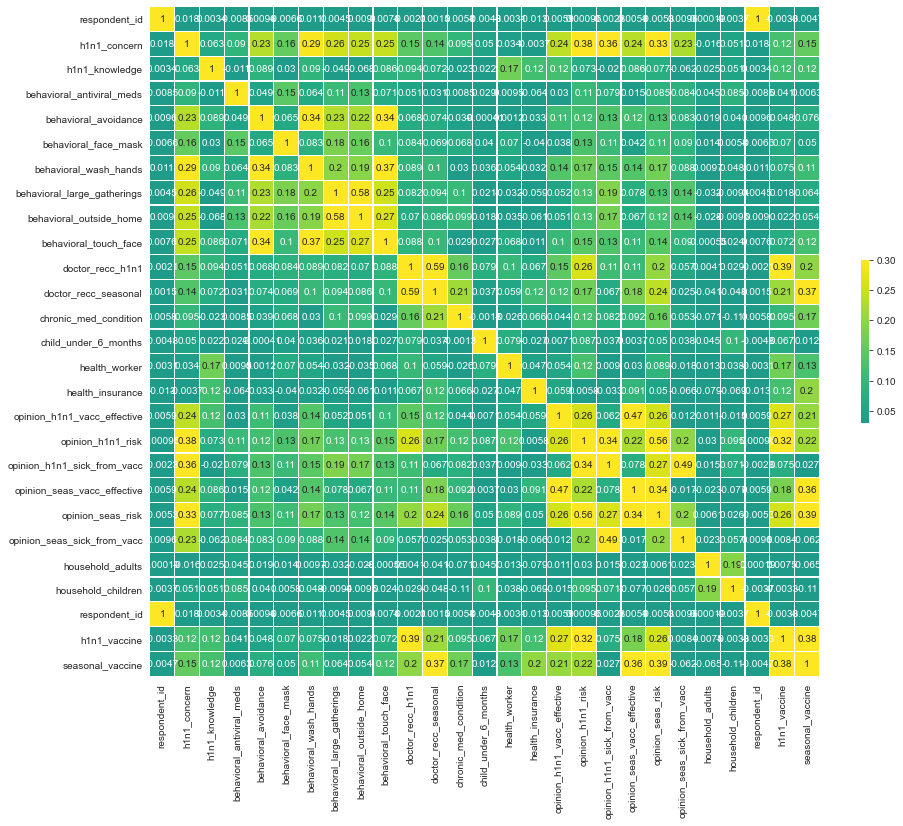

In [82]:
# Checking for Correlation matrix
plt.figure(figsize=(15,15))
sns.heatmap(corr,cmap='viridis', vmax=.3 ,vmin=.03 ,center=0,square=True, linewidths=.2, cbar_kws={"shrink": .2}, annot=True)

###### Checking for Outlier

<AxesSubplot:>

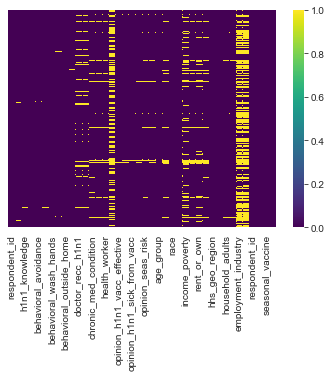

In [83]:
sns.set_style('whitegrid')
sns.heatmap(vaccine_data.isnull(),yticklabels=False,cbar=True,cmap='viridis')

###### Visualization using 'Pandas Profiling'

In [84]:
from pandas_profiling import ProfileReport
prof = ProfileReport(feature_data)
prof.to_file(output_file='output.html')

###### Label Encoding

In [85]:
labelencoder = LabelEncoder()

In [86]:
objList = vaccine_data.select_dtypes(include = "object").columns
objList

Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation', 'status'],
      dtype='object')

In [87]:
for feat in objList:
    vaccine_data[feat] = labelencoder.fit_transform(vaccine_data[feat].astype(str))

In [88]:
vaccine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [89]:
vaccine_data.head(20)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,respondent_id,h1n1_vaccine,seasonal_vaccine,status
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,8,2,0.0,0.0,10,11,0,0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1,0,0.0,0.0,13,20,1,0,1,2
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,9,0,2.0,0.0,15,22,2,0,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,5,1,0.0,0.0,10,11,3,0,1,2
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,9,0,1.0,0.0,19,5,4,0,0,0
5,5,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0,1,2.0,3.0,16,19,5,0,0,0
6,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,0,0.0,0.0,20,22,6,0,0,0
7,7,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1,2,2.0,0.0,13,21,7,1,1,1
8,8,0.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1,0,1.0,0.0,20,1,8,0,0,0
9,9,2.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,9,0,0.0,0.0,10,11,9,0,0,0


###### Defining 'X' data & 'y' & Training the dataset

In [90]:
X_DT=vaccine_data.iloc[:,:-3]
y_DT=vaccine_data.status

In [91]:
X_DT.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,respondent_id
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1,0,1,8,2,0.0,0.0,10,11,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1,1,0,1,0,0.0,0.0,13,20,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,9,0,2.0,0.0,15,22,2
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1,1,1,5,1,0.0,0.0,10,11,3
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0,0,0,9,0,1.0,0.0,19,5,4


In [92]:
y_DT=vaccine_data.status

In [93]:
y_DT.head(20)

0     0
1     2
2     0
3     2
4     0
5     0
6     0
7     1
8     0
9     0
10    1
11    1
12    2
13    0
14    0
15    0
16    1
17    0
18    0
19    0
Name: status, dtype: int32

In [94]:
X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(X_DT, y_DT, test_size=0.25, random_state=10)

In [95]:
XGBoostError = ""
LightGBMError = ""
ValueError = ""
def plot_feature_importances(clf, X_train, y_train=None, 
                             top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
    '''
    plot feature importances of a tree-based sklearn estimator
    
    Note: X_train and y_train are pandas DataFrames
    
    Note: Scikit-plot is a lovely package but I sometimes have issues
              1. flexibility/extendibility
              2. complicated models/datasets
          But for many situations Scikit-plot is the way to go
          see https://scikit-plot.readthedocs.io/en/latest/Quickstart.html
    
    Parameters
    ----------
        clf         (sklearn estimator) if not fitted, this routine will fit it
        
        X_train     (pandas DataFrame)
        
        y_train     (pandas DataFrame)  optional
                                        required only if clf has not already been fitted 
        
        top_n       (int)               Plot the top_n most-important features
                                        Default: 10
                                        
        figsize     ((int,int))         The physical size of the plot
                                        Default: (8,8)
        
        print_table (boolean)           If True, print out the table of feature importances
                                        Default: False
        
    Returns
    -------
        the pandas dataframe with the features and their importance
        
    Author
    ------
        George Fisher
    '''
    
    __name__ = "plot_feature_importances"
    
    
    try: 
        if not hasattr(clf, 'feature_importances_'):
            clf.fit(X_train.values, y_train.values.ravel())

            if not hasattr(clf, 'feature_importances_'):
                raise AttributeError("{} does not have feature_importances_ attribute".
                                    format(clf.__class__.__name__))
                
    #except (XGBoostError, LightGBMError, ValueError):
    except:
        clf.fit(X_train.values, y_train.values.ravel())
            
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    plt.rcParams.update({'figure.autolayout': True})
    #plt.rcParams["axes.edgecolor"] = "0.15"
    #plt.rcParams["axes.linewidth"]  = 1.25
    #plt.grid()

    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(figsize=figsize)
    #plt.title("Feature Importances", fontsize = 15, fontweight="bold")
    plt.xlabel('Feature Importance Score', fontsize = 15)
    plt.ylabel('Features', fontsize = 15)
    plt.savefig('Feature_Importance_before_scaling_ohe.png')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

In [96]:
plot_feature_importances(RandomForestClassifier(random_state=rand_state), X_train_DT, y_train_DT, top_n=10, figsize=(5,5))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [97]:
#X_DT = Project_Data.drop(columns=['y', 'duration'], axis=1)
#y_DT = Project_Data.y

In [98]:
#X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(X_DT, y_DT, test_size=0.25, random_state=10)

In [99]:
#clf = DecisionTreeClassifier(max_depth=5)
#clf = clf.fit(X_train_DT,y_train_DT)
#y_pred = clf.predict(X_test_DT)

In [100]:
#dot_data = tree.export_graphviz(clf, out_file=None, 
                                #feature_names=X_train_DT.columns,  
                                #class_names=['no', 'yes'],
                               # filled=True)

# Draw graph
#graph = graphviz.Source(dot_data, format="png") 
#graph
#graph.render("DT")

###### Scaling the data set

In [101]:
scaler = MinMaxScaler()

In [102]:
vaccine_data_scaled = pd.DataFrame(scaler.fit_transform(vaccine_data), columns=vaccine_data.columns)

In [103]:
#Project_Data_svm_Encoded_scaled = pd.DataFrame(scaler.fit_transform(Project_Data_svm_Encoded), columns=Project_Data_svm_Encoded.columns)

In [104]:
vaccine_data_scaled.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,respondent_id,h1n1_vaccine,seasonal_vaccine,status
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,...,26707.000000,26707.000000,26458.000000,26458.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000
mean,0.500000,0.539495,0.631266,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,...,0.536638,0.416745,0.295500,0.178194,0.476807,0.501534,0.500000,0.212454,0.465608,0.414255
std,0.288691,0.303437,0.309075,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,...,0.311776,0.411657,0.251141,0.309391,0.239954,0.226333,0.288691,0.409052,0.498825,0.445744
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.333333,0.500000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,...,0.333333,0.000000,0.000000,0.000000,0.380952,0.434783,0.250000,0.000000,0.000000,0.000000
50%,0.500000,0.666667,0.500000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,...,0.555556,0.500000,0.333333,0.000000,0.476190,0.478261,0.500000,0.000000,0.000000,0.500000
75%,0.750000,0.666667,1.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,...,0.777778,1.000000,0.333333,0.333333,0.476190,0.478261,0.750000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


###### SMOTE

In [106]:
X = vaccine_data_scaled.drop(columns=['status', 'h1n1_vaccine','seasonal_vaccine'], axis=1)
y = vaccine_data_scaled.status
smote = SMOTE()
X_smote, y_smote = smote.fit_sample(X.astype('float'), y)

ValueError: Unknown label type: 'continuous'